Populating the interactive namespace from numpy and matplotlib


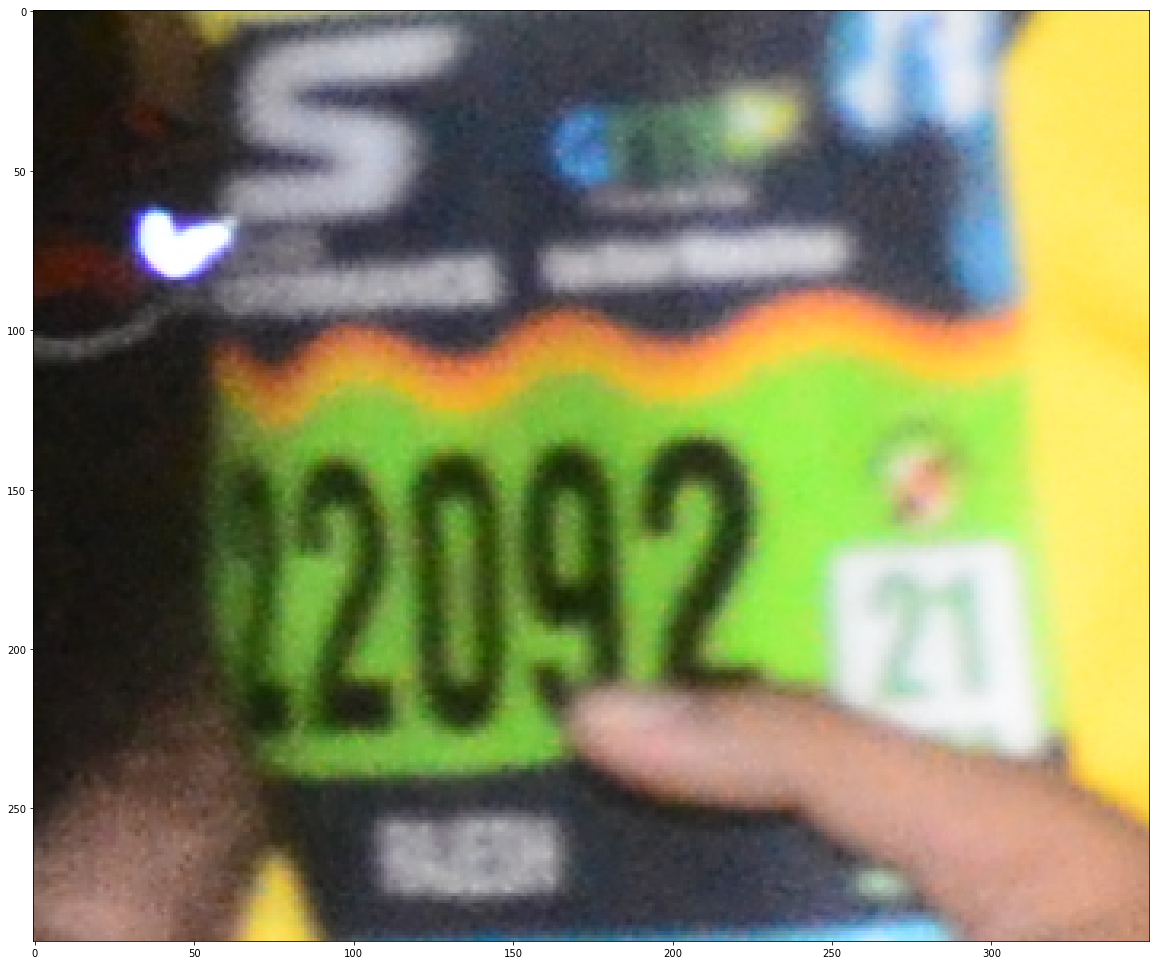

In [110]:
import os
import cv2
import re
import json
import numpy as np
import matplotlib.pyplot as plt
%pylab inline
pylab.rcParams['figure.figsize'] = (20, 20)

def crop_region(image, region):
    """Crops a singular region in an image
    Args:
        image (image): A numpy image
        region (dict): A dictionary containing x1, y1, x2, y2
    Returns:
        image: The cropped image
    """
    x1 = region["x1"] 
    y1 = region["y1"]
    w = region["x2"] - x1
    h = region["y2"] - y1
    return image[y1: y1 + h, x1: x1 + w]

def region_area(region):
    """Returns the area of the specified region.
    Args:
        region (dict): A dictionary containing {x1, y1, x2, y2} arguments.
    Returns:
        float: The area of the region.
    """
    w = region["x2"] - region["x1"]
    h = region["y2"] - region["y1"]
    return w * h

def do_regions_intersect(r1, r2):
    """Calculates whether or not the two regions intersect eachother.
    Args:
        r1, r2 (dict): A dictionary containing {x1, y1, x2, y2} arguments.
    Returns:
        boolean: True if the regions intersect, false otherwise.
    """
    dx = min(r1["x2"], r2["x2"]) - max(r1["x1"], r2["x1"])
    dy = min(r1["y2"], r2["y2"]) - max(r1["y1"], r2["y1"])
    return (dx > 0) and (dy > 0)

def read_json(json_filename):
    """Reads the JSON file as a dictionary.
    Args:
        json_filename (string): The JSON file to read.
    Returns:
        dict: The JSON data, parsed as a dictionary.
    """
    with open(json_filename, 'r') as json_fp:
        json_data = json.load(json_fp)
    return json_data

def crop_bibs_from_image(image_filename, bib_json_dir, person_json_dir = None):
    """Crop an image using the bib region.
    Args:
        image_filename (string): Path to ORIGINAL image filename.
        bib_json_dir (string): Path of bib JSON files.
        person_json_dir (string): Path of person crop JSON files. If not provided,
                                  then assume non-crop images provided.
    Returns:
        list of numpy3d: a list of the cropped bibs.
    """
    # Strip the image id from the original filename
    image_id = os.path.splitext(os.path.basename(image_filename))[0]
    
    # Read in the image
    image = cv2.imread(image_filename)
    
    # If a person JSON directory is provided, then we need to combine all
    # detected bibs for each respective person
    if person_json_dir is not None:
        person_regions = read_json("%s/%s.json" % (person_json_dir, image_id))["person"]["regions"]
        
        # Now I have all of my person_regions, I cna find the respective bib regions
        # for every single person
        for i, person_region in enumerate(person_regions):
            # These are the person's coordinates in the ORIGINAL image
            px1, py1 = (person_region["x1"], person_region["y1"])
            bib_filename = "%s/%s_crop_person_%i.json" % (bib_json_dir, image_id, i)
            person_region["bib_regions"] = read_json(bib_filename)["bib"]["regions"]
            
            # Now we must mutate each of these bib regions to be reflective
            # of the ORIGINAL image's dimension sizes
            for bib_region in person_region["bib_regions"]:
                bib_region["x1"] += px1
                bib_region["y1"] += py1
                bib_region["x2"] += px1
                bib_region["y2"] += py1
        
        # Now strip out all bib regions in the entire photo for every runner
        bib_regions = np.hstack([person_region["bib_regions"] for person_region in person_regions])

        # Go through every bib region we have, and see if any bibs overlap.
        # If they do, then use the larger area rectangle.
        bib_regions_to_remove = []
        for bib_region in bib_regions:
            for other_bib_region in bib_regions:
                if bib_region == other_bib_region:
                    continue
                if do_regions_intersect(bib_region, other_bib_region):
                    bib_region_area = region_area(bib_region)
                    other_bib_region_area = region_area(other_bib_region)
                    if bib_region_area > other_bib_region_area:
                        bib_regions_to_remove.append(other_bib_region)
        bib_regions = [bib_region for bib_region in bib_regions 
                       if bib_region not in bib_regions_to_remove]
    else:
        bib_regions = read_json("%s/%s.json" % (bib_json_dir, image_id))["bib"]["regions"]
    
    return [crop_region(image, bib_region) for bib_region in bib_regions]


bibs = crop_bibs_from_image("/Users/Alex/Desktop/yolo_crop/run4/2dc85b4090468f66b12eaaf8c1a76c8a.jpg",
                            "/Users/Alex/Desktop/yolo_crop/run4/bib",
                            "/Users/Alex/Desktop/yolo_crop/run4/person")